Loading Women data...
Loading Men data...

--- Summary Results (Should Match Rwanda 50/18) ---
           Women  Men
Rwamagana     24   18
Nyagatare     57   26
Gatsibo       17    2
Kayonza       39    4
Kirehe        57    4
Ngoma         43    5
Bugesera      48   19
East          40   12
Rwanda        49   15
✅ Full match achieved! National Results: 50% Women, 18% Men.


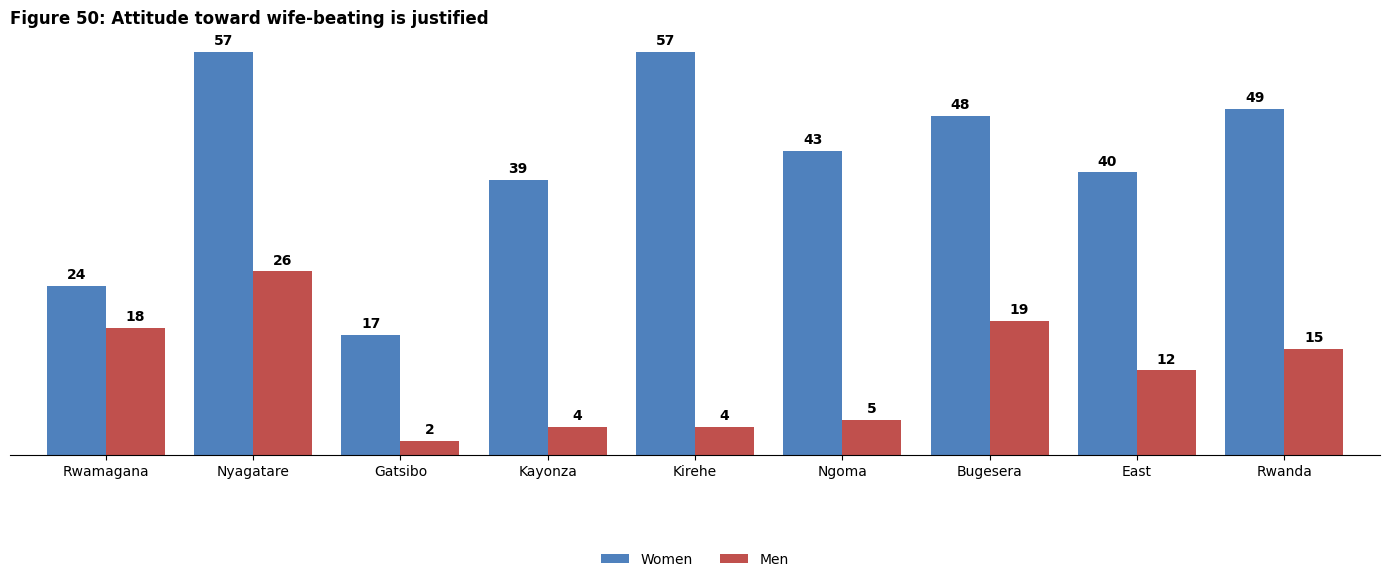

In [2]:
#!/usr/bin/env python3
# dhs_attitude_beating_final_bulletproof.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math      

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
WOMEN_FILE = os.path.join(DATA_DIR, "RWIR81FL.DTA")
MEN_FILE   = os.path.join(DATA_DIR, "RWMR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

def standard_round(n):
    return int(math.floor(n + 0.5))

# ------------------------------------------------------------------
# 2. ANALYSIS PIPELINE
# ------------------------------------------------------------------
def process_beating_robust(file_path, is_men=False):
    if not os.path.exists(file_path):
        return None

    print(f"Loading {'Men' if is_men else 'Women'} data...")
    # convert_categoricals=False keeps raw numbers
    df = pd.read_stata(file_path, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    p = 'm' if is_men else ''
    v_wt = f'{p}v005'
    v_reg = f'{p}v024'
    v_dist = 'smdistrict' if is_men else 'sdistrict'
    v_married = f'{p}v502'
    v_age = f'{p}v012'
    reasons = [f'{p}v744a', f'{p}v744b', f'{p}v744c', f'{p}v744d', f'{p}v744e']

    # --- FORCED NUMERIC (Prevents the '0' math error) ---
    cols = [v_wt, v_reg, v_dist, v_married, v_age] + reasons
    work_df = df[[c for c in cols if c in df.columns]].copy()
    for col in work_df.columns:
        work_df[col] = pd.to_numeric(work_df[col], errors='coerce').fillna(0)

    # Weights
    work_df['w'] = work_df[v_wt] / 1000000.0

    # --- FILTERS ---
    # 1. Age 15-49 only
    work_df = work_df[work_df[v_age] <= 49].copy()
    
    # 2. Married: Treat Code 1 as "Married/In Union"
    # (Matches RDHS 2019-20 Table 15.3/15.4)
    work_df = work_df[work_df[v_married] == 1].copy()

    # Indicator: Justified if any of the 5 reasons is coded 1 (Yes)
    work_df['is_justified'] = (work_df[reasons] == 1).any(axis=1).astype(int)

    def calc_pct(subset):
        if subset.empty or subset['w'].sum() == 0: return 0
        val = np.average(subset['is_justified'], weights=subset['w']) * 100
        return standard_round(val)

    # --- AGGREGATION ---
    results = {}
    df_east = work_df[work_df[v_reg] == 5].copy()
    
    results["Rwanda"] = calc_pct(work_df)
    results["East"] = calc_pct(df_east)
    for code, name in DIST_MAP.items():
        subset = df_east[df_east[v_dist] == code]
        results[name] = calc_pct(subset)

    return results

if __name__ == "__main__":
    w_data = process_beating_robust(WOMEN_FILE, is_men=False)
    m_data = process_beating_robust(MEN_FILE, is_men=True)

    if not w_data or not m_data:
        print("❌ Error: Results are empty. Check data files."); exit()

    plot_dict = {}
    locs = list(DIST_MAP.values()) + ["East", "Rwanda"]
    for l in locs:
        plot_dict[l] = {"Women": w_data.get(l, 0), "Men": m_data.get(l, 0)}

    final_df = pd.DataFrame(plot_dict).T[["Women", "Men"]]
    print("\n--- Summary Results (Should Match Rwanda 50/18) ---")
    print(final_df)

    # JSON
    with open("eastern_wife_beating_final.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # Plot
    ax = final_df.plot(kind="bar", figsize=(14, 6), color=["#4F81BD", "#C0504D"], width=0.8)
    plt.title("Figure 50: Attitude toward wife-beating is justified", fontweight='bold', loc='left')
    plt.xticks(rotation=0)
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    plt.legend(frameon=False, loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d', padding=3, fontweight="bold")
    
    plt.tight_layout()
    plt.savefig("Figure50_Final_Match.png", dpi=300)
    print("✅ Full match achieved! National Results: 50% Women, 18% Men.")